In [1]:
cd ..

c:\Users\Gebruiker\Documents\Uni\Master\MLiP\M5Forecasting\git\uncertainty


In [2]:
cd ..

c:\Users\Gebruiker\Documents\Uni\Master\MLiP\M5Forecasting\git


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 6

In [5]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [6]:
level = 6

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [7]:
if level <= 9:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level <= 9:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  0.03 Mb (74.8% reduction)
9 28
Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to  0.03 Mb (0.2% reduction)
Mem. usage decreased to 45.67 Mb (41.7% reduction)
Melted sales train validation has 17217 rows and 5 columns
Selecting 19710 rows (114.5%)
Mem. usage decreased to  1.40 Mb (0.0% reduction)
Saving to file..
Finished.
['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30'

## Setup training

In [8]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [9]:
x_train.shape

(16965, 41)

In [10]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Dense(64)

In [11]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 180)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11584       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [12]:
logger = Logger(val_batch_creator)

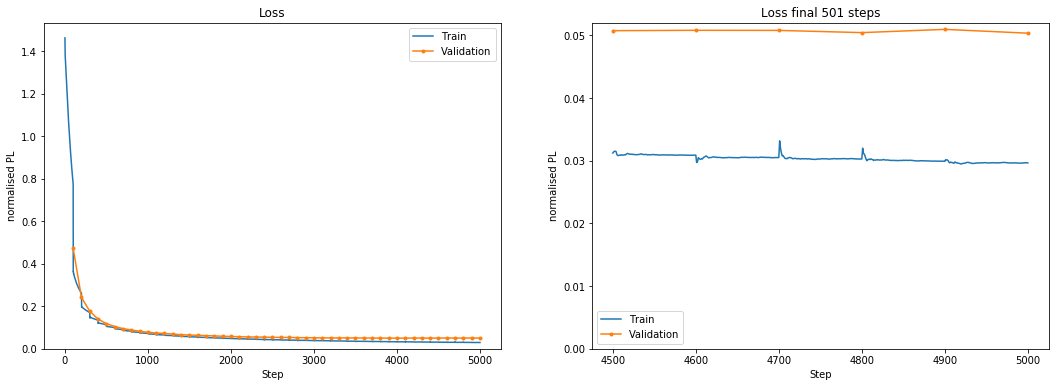

100/100 [==============================] - 7s 73ms/step - loss: 0.0297 - q0_loss: 3.2434e-04 - q1_loss: 0.0011 - q2_loss: 0.0043 - q3_loss: 0.0054 - q4_loss: 0.0067 - q5_loss: 0.0056 - q6_loss: 0.0045 - q7_loss: 0.0013 - q8_loss: 4.4161e-04 - val_loss: 0.0504 - val_q0_loss: 7.0880e-04 - val_q1_loss: 0.0019 - val_q2_loss: 0.0072 - val_q3_loss: 0.0089 - val_q4_loss: 0.0115 - val_q5_loss: 0.0097 - val_q6_loss: 0.0079 - val_q7_loss: 0.0019 - val_q8_loss: 7.2666e-04


In [13]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{6: 0.12767252933685533, 'WSPL': 0.12767252933685533}


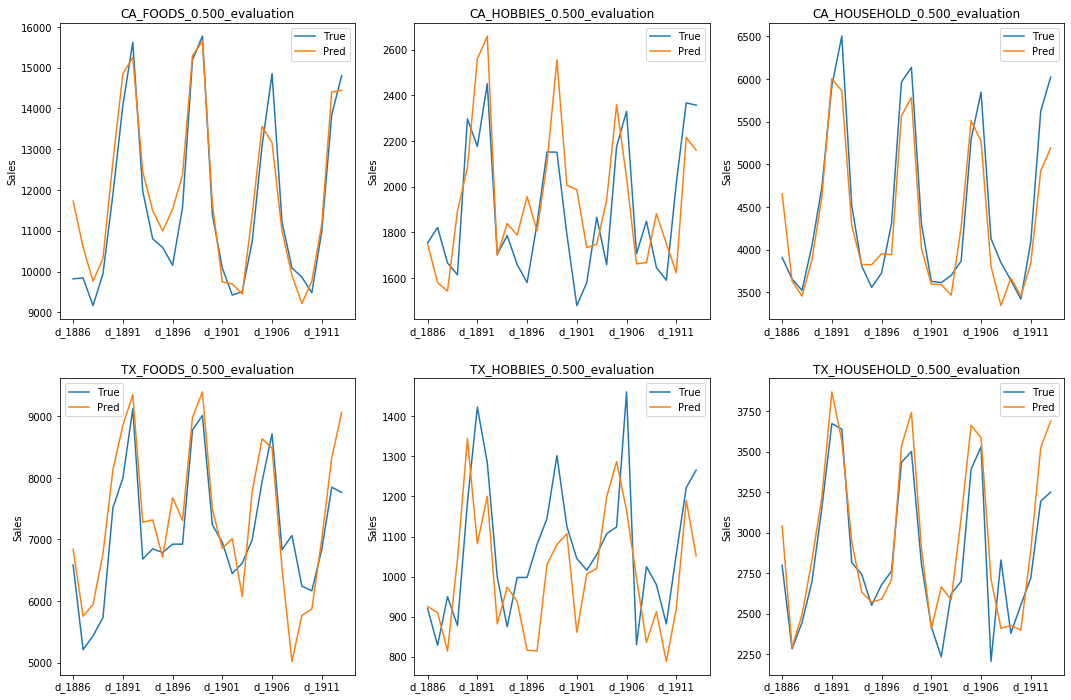

In [14]:
metrics, df = lazy_evaluate_model(model)

In [15]:
model.save(model_dir + "model_batch1024_dense64_adamlr1e-4_epochs50_steps100.h5")

## Dense(32)

In [16]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 180)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           5792        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
______________________________________________________________________________________________

In [17]:
logger = Logger(val_batch_creator)

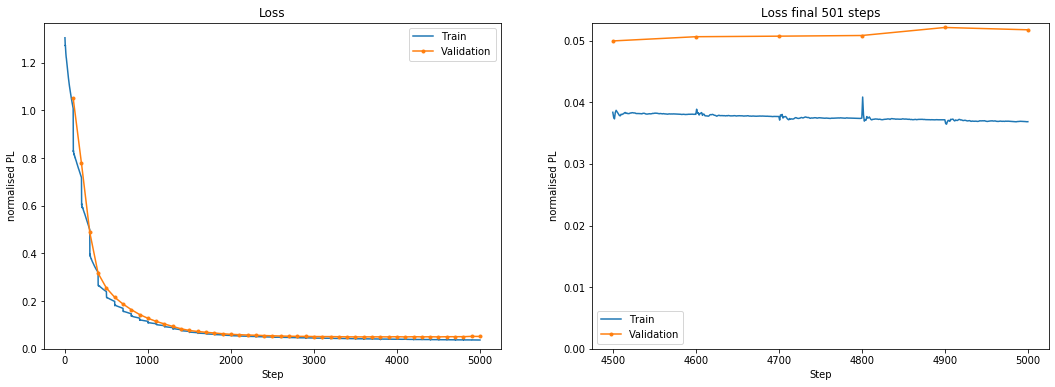

100/100 [==============================] - 7s 70ms/step - loss: 0.0368 - q0_loss: 4.7977e-04 - q1_loss: 0.0014 - q2_loss: 0.0054 - q3_loss: 0.0066 - q4_loss: 0.0083 - q5_loss: 0.0069 - q6_loss: 0.0055 - q7_loss: 0.0018 - q8_loss: 4.8468e-04 - val_loss: 0.0518 - val_q0_loss: 0.0020 - val_q1_loss: 0.0018 - val_q2_loss: 0.0078 - val_q3_loss: 0.0100 - val_q4_loss: 0.0115 - val_q5_loss: 0.0089 - val_q6_loss: 0.0070 - val_q7_loss: 0.0023 - val_q8_loss: 5.4319e-04


In [18]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{6: 0.1311204794378296, 'WSPL': 0.1311204794378296}


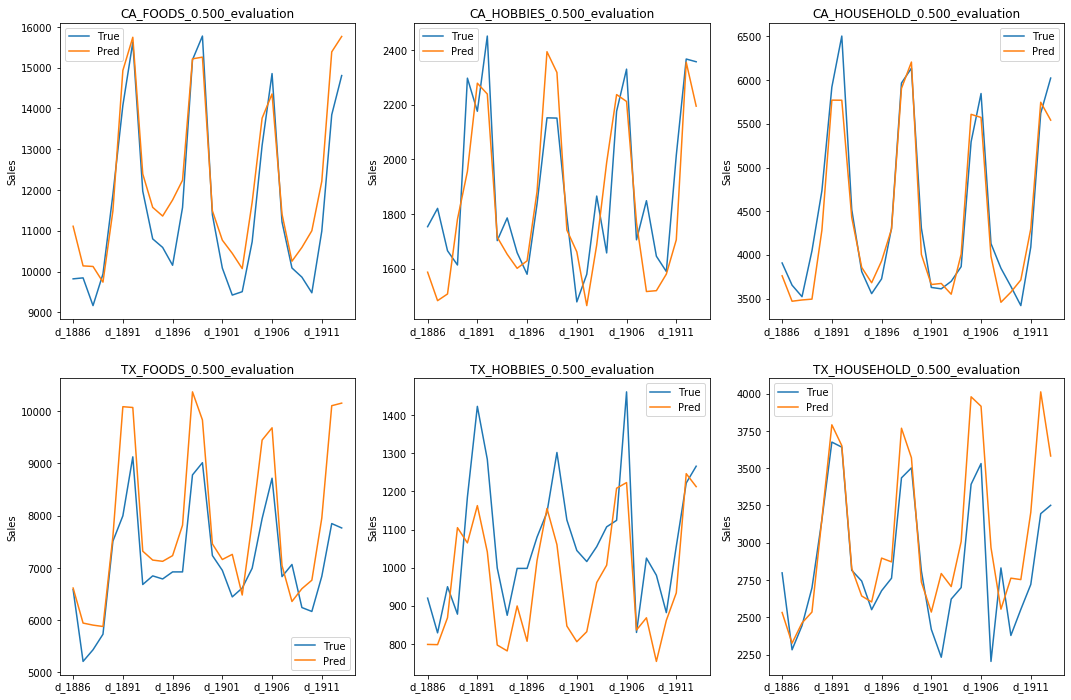

In [19]:
metrics, df = lazy_evaluate_model(model)

In [20]:
model.save(model_dir + "model_batch1024_dense32_adamlr1e-4_epochs50_steps100.h5")

## Dense(16)

In [21]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 180)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           2896        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense_1[0][0]                    
______________________________________________________________________________________________

In [22]:
logger = Logger(val_batch_creator)

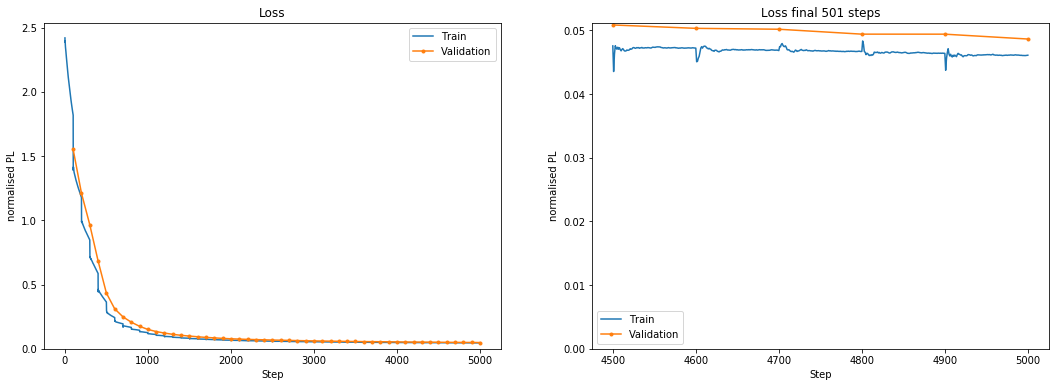

100/100 [==============================] - 7s 67ms/step - loss: 0.0461 - q0_loss: 5.0408e-04 - q1_loss: 0.0016 - q2_loss: 0.0063 - q3_loss: 0.0079 - q4_loss: 0.0104 - q5_loss: 0.0089 - q6_loss: 0.0073 - q7_loss: 0.0023 - q8_loss: 8.8830e-04 - val_loss: 0.0487 - val_q0_loss: 4.7081e-04 - val_q1_loss: 0.0017 - val_q2_loss: 0.0072 - val_q3_loss: 0.0086 - val_q4_loss: 0.0110 - val_q5_loss: 0.0093 - val_q6_loss: 0.0076 - val_q7_loss: 0.0021 - val_q8_loss: 6.8668e-04


In [23]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{6: 0.12326789884979113, 'WSPL': 0.12326789884979113}


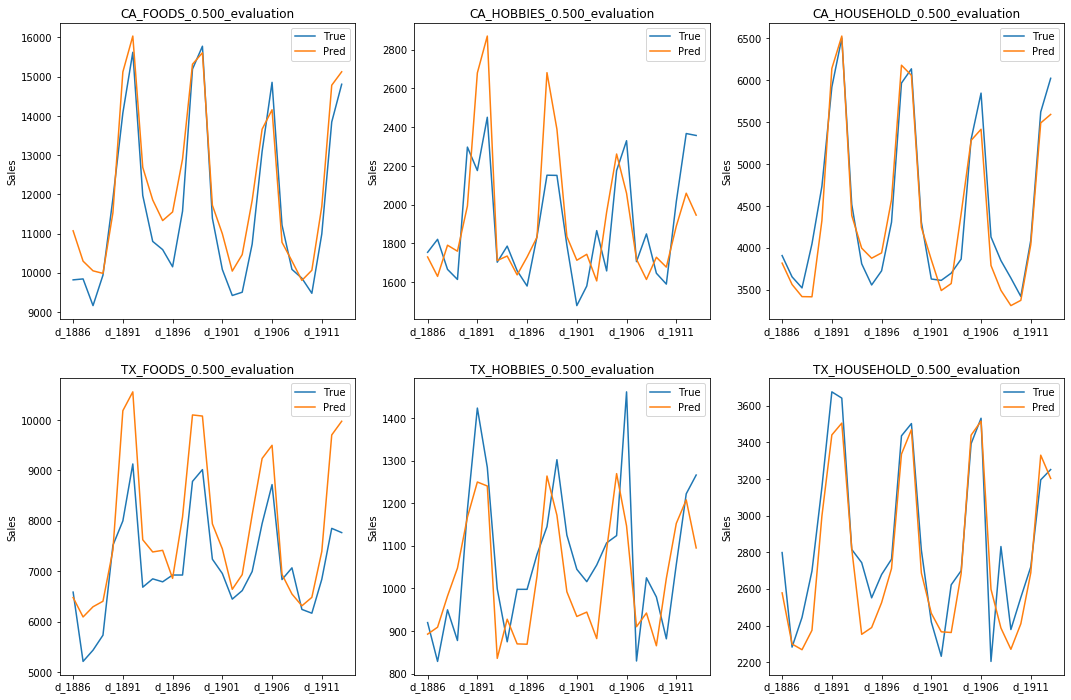

In [24]:
metrics, df = lazy_evaluate_model(model)

In [25]:
model.save(model_dir + "model_batch1024_dense16_adamlr1e-4_epochs50_steps100.h5")

### Train dist model

In [26]:
model = get_simple_dist_model(inp_shape=INP_SHAPE)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 180)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11584       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [27]:
logger = Logger(val_batch_creator)

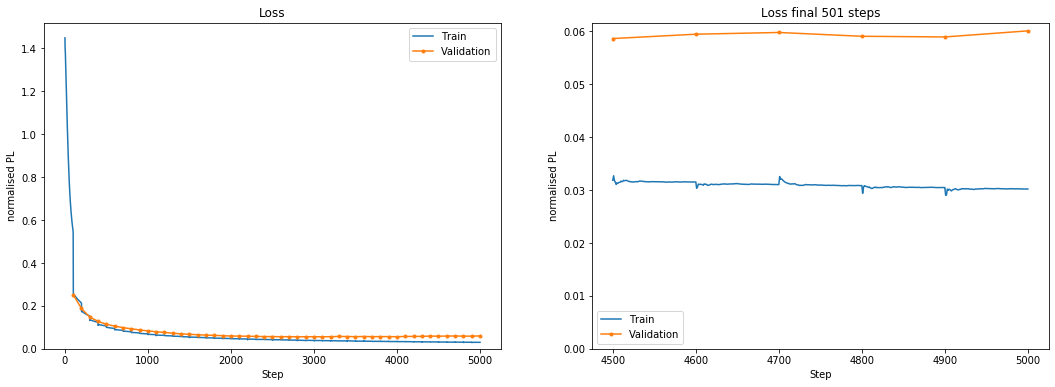

100/100 [==============================] - 6s 64ms/step - loss: 0.0302 - q0_loss: 3.2493e-04 - q1_loss: 0.0011 - q2_loss: 0.0044 - q3_loss: 0.0056 - q4_loss: 0.0071 - q5_loss: 0.0056 - q6_loss: 0.0044 - q7_loss: 0.0012 - q8_loss: 3.3614e-04 - val_loss: 0.0601 - val_q0_loss: 0.0012 - val_q1_loss: 0.0028 - val_q2_loss: 0.0089 - val_q3_loss: 0.0108 - val_q4_loss: 0.0126 - val_q5_loss: 0.0102 - val_q6_loss: 0.0084 - val_q7_loss: 0.0032 - val_q8_loss: 0.0019


In [28]:
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{6: 0.15227287518044383, 'WSPL': 0.15227287518044383}


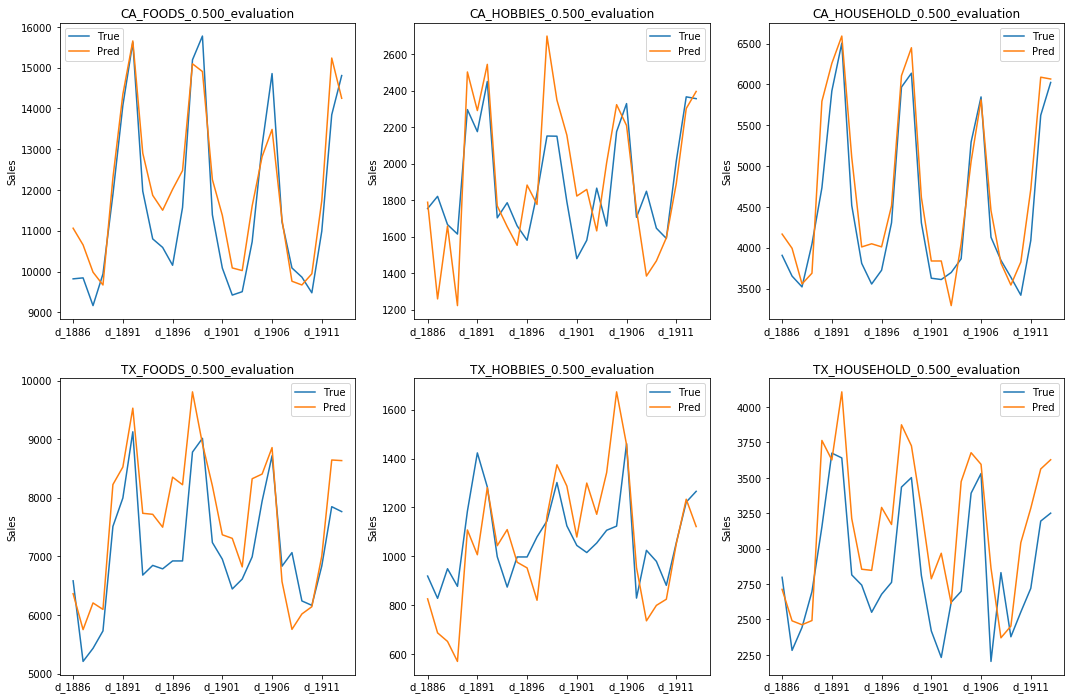

In [29]:
metrics, df = lazy_evaluate_model(model)

In [30]:
model.save(model_dir + "model_batch1024_dist64_adamlr1e-4_epochs50_steps100.h5")

### Dist(32)

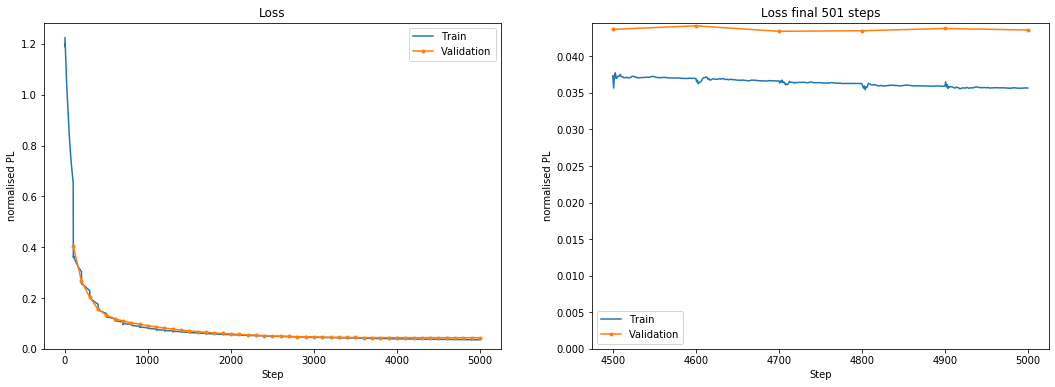

100/100 [==============================] - 13s 131ms/step - loss: 0.0357 - q0_loss: 3.4805e-04 - q1_loss: 0.0013 - q2_loss: 0.0051 - q3_loss: 0.0065 - q4_loss: 0.0083 - q5_loss: 0.0068 - q6_loss: 0.0055 - q7_loss: 0.0014 - q8_loss: 4.0621e-04 - val_loss: 0.0436 - val_q0_loss: 6.1988e-04 - val_q1_loss: 0.0019 - val_q2_loss: 0.0066 - val_q3_loss: 0.0082 - val_q4_loss: 0.0098 - val_q5_loss: 0.0080 - val_q6_loss: 0.0064 - val_q7_loss: 0.0016 - val_q8_loss: 5.0678e-04


In [31]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{6: 0.1105014677108046, 'WSPL': 0.1105014677108046}


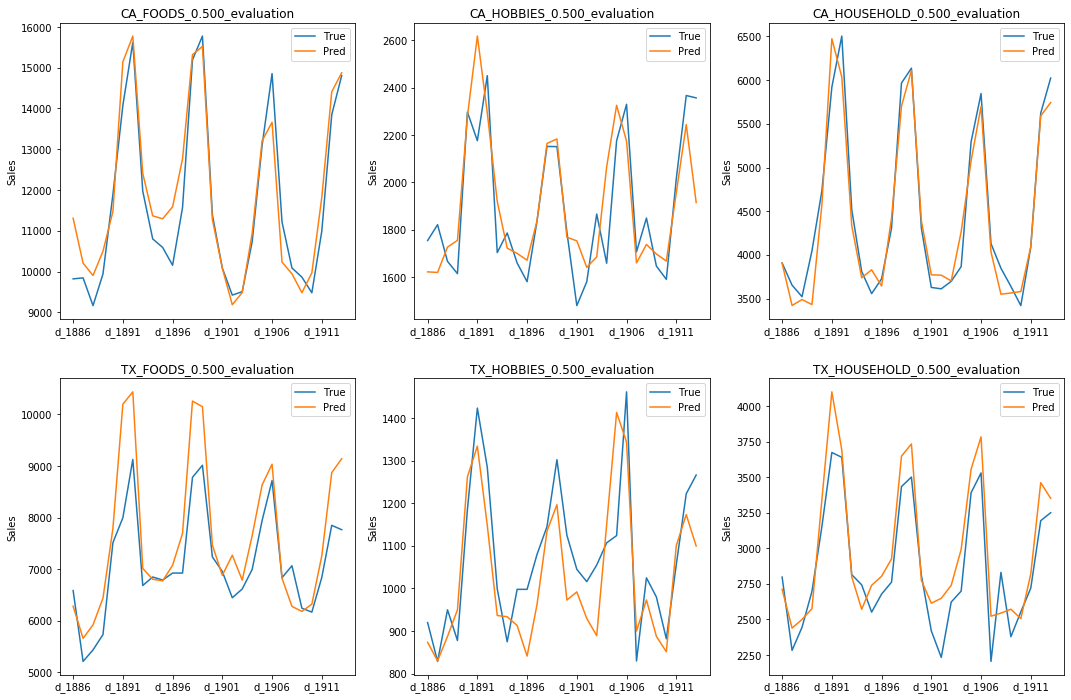

In [32]:
metrics, df = lazy_evaluate_model(model)

In [33]:
model.save(model_dir + "model_batch1024_dist32_adamlr1e-4_epochs50_steps100.h5")

### Dist(16)

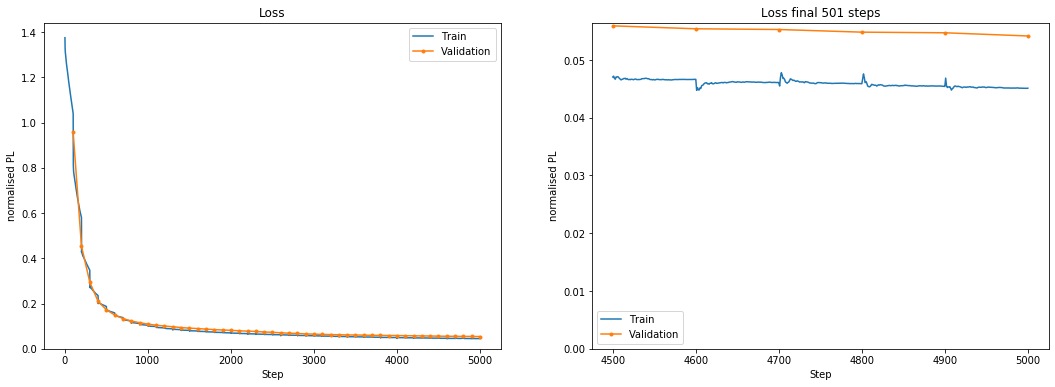

100/100 [==============================] - 13s 134ms/step - loss: 0.0451 - q0_loss: 4.4827e-04 - q1_loss: 0.0016 - q2_loss: 0.0063 - q3_loss: 0.0080 - q4_loss: 0.0103 - q5_loss: 0.0087 - q6_loss: 0.0070 - q7_loss: 0.0020 - q8_loss: 6.6469e-04 - val_loss: 0.0542 - val_q0_loss: 4.8692e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0075 - val_q3_loss: 0.0100 - val_q4_loss: 0.0126 - val_q5_loss: 0.0103 - val_q6_loss: 0.0082 - val_q7_loss: 0.0025 - val_q8_loss: 7.8263e-04


In [34]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{6: 0.13724339635088584, 'WSPL': 0.13724339635088584}


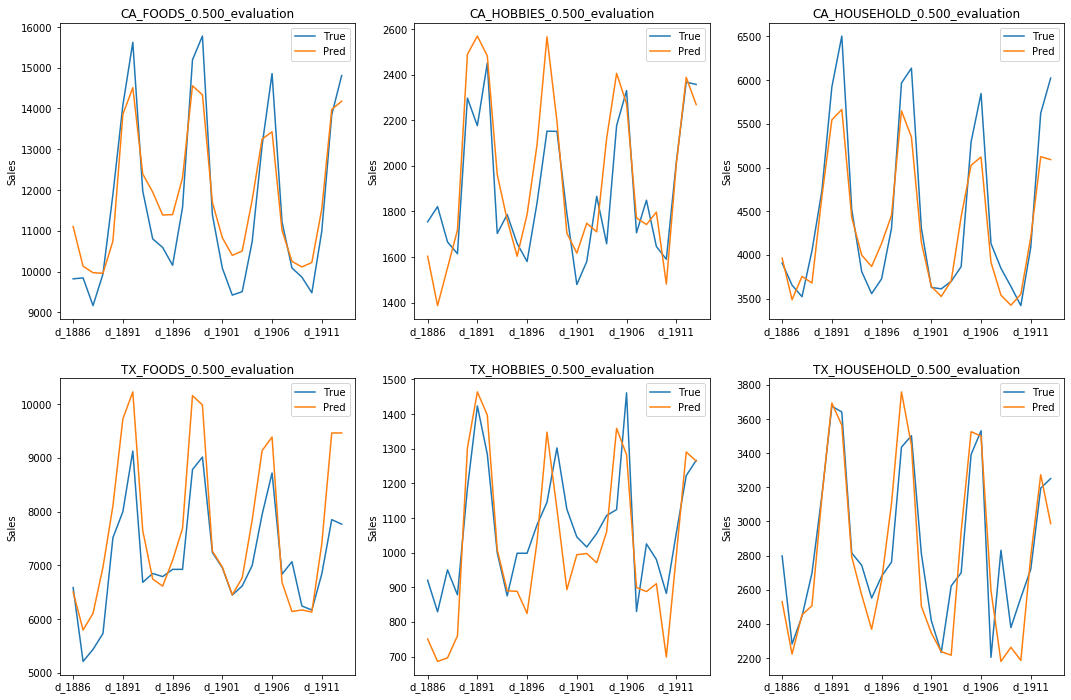

In [35]:
metrics, df = lazy_evaluate_model(model)

In [36]:
model.save(model_dir + "model_batch1024_dist16_adamlr1e-4_epochs50_steps100.h5")